In [9]:
#библиотеки
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils

In [10]:
#пути
DATA_DIR = '../roads_dataset/tiff/'
#изначально датасет был поделён на тест, треин и вал части, поэтому ничего делить не пришлось
#треин
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')
#валидация
x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')
#тест
x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [11]:
#читаем данные с ексель файла с некоторыми значениями
class_dict = pd.read_csv("../roads_dataset/label_class_dict.csv") #значение каналов классов
select_classes = class_dict['name'].tolist() #название классов (дорога и фон)
class_rgb_values = class_dict[['r','g','b']].values.tolist()# Значение каналов класса

#вывод инфы
print('Class Names: ', select_classes)
print('Class RGB values: ', class_rgb_values)

Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [12]:
select_class_indices = [select_classes.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

In [13]:
#функция для вывода данных
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

    
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)#выполняет сравнение
        class_map = np.all(equality, axis = -1)#проверяет налич всех элементов на оси от посл оси к 1
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)#переворот
    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)#возвр ид макс знач
    return x


def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

In [14]:
class RoadsDataset(torch.utils.data.Dataset):
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir)) if not image_id.startswith('.')]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir)) if not image_id.startswith('.')]
        if "../roads_dataset/tiff/train/.ipynb_checkpoints" in self.image_paths:
            print("nashol")
            
#         print(self.image_paths)
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

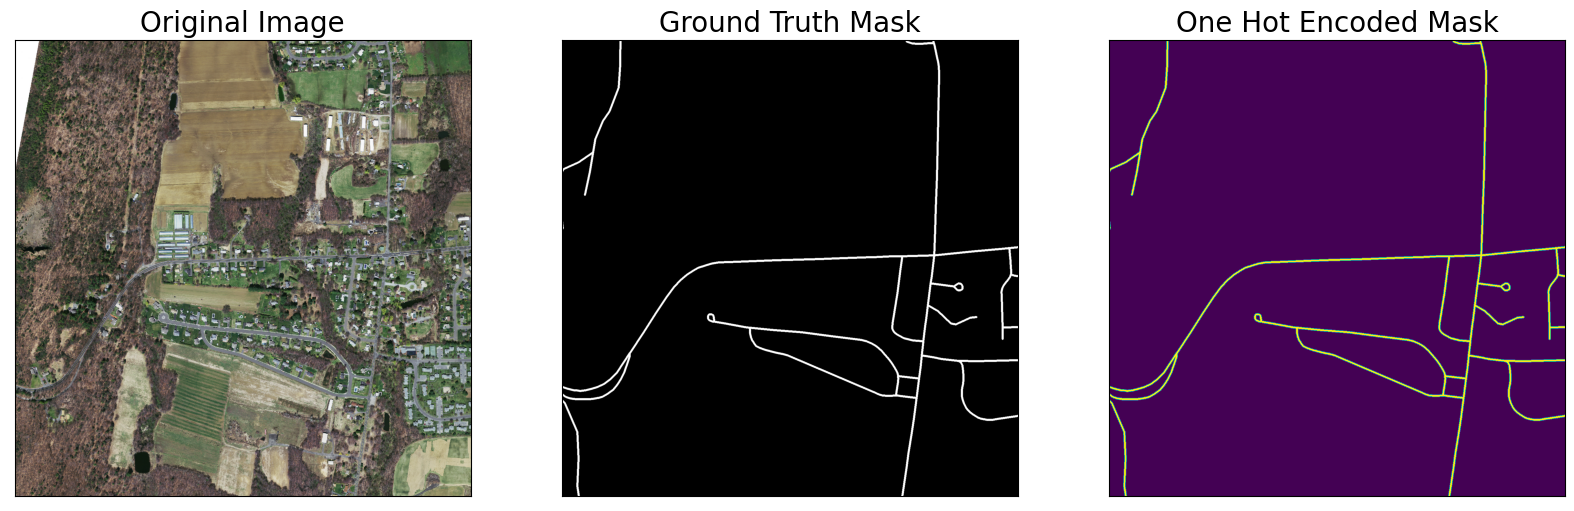

In [15]:
dataset = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [16]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None): 
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

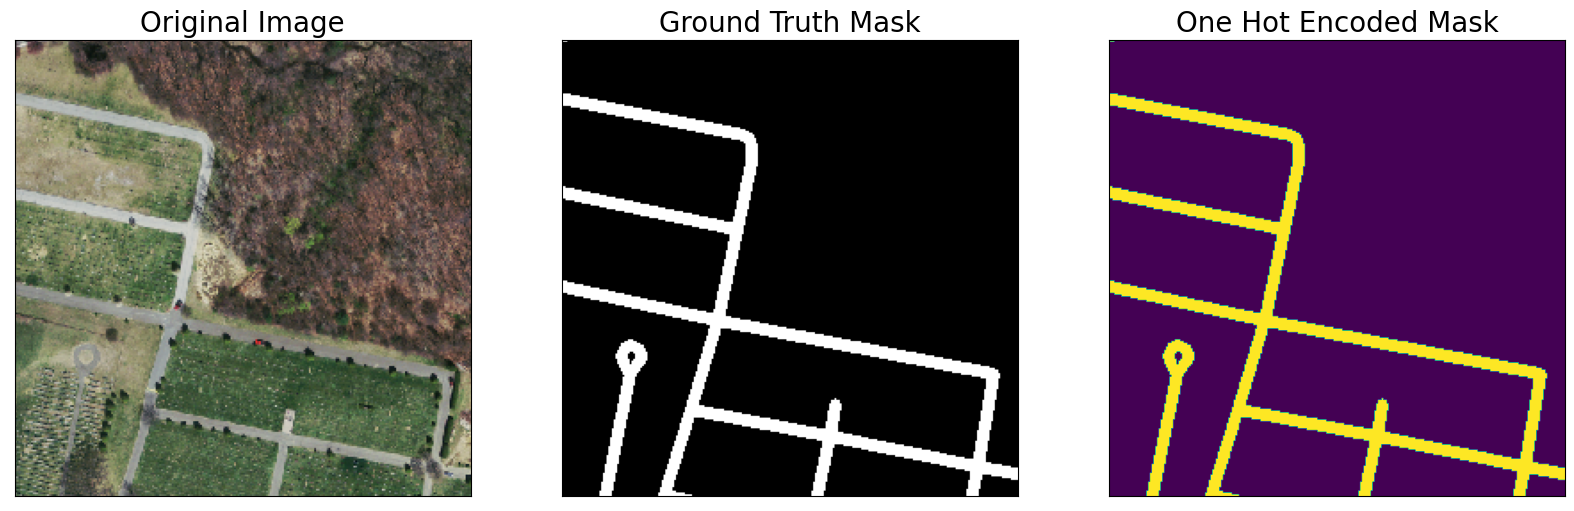

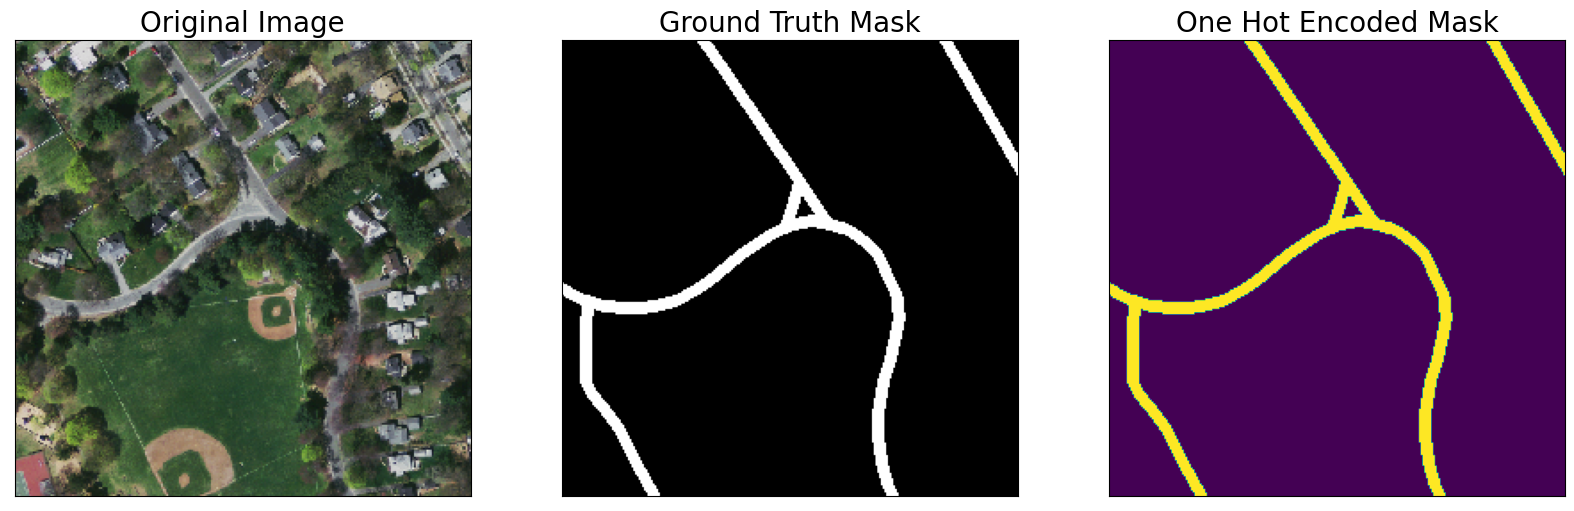

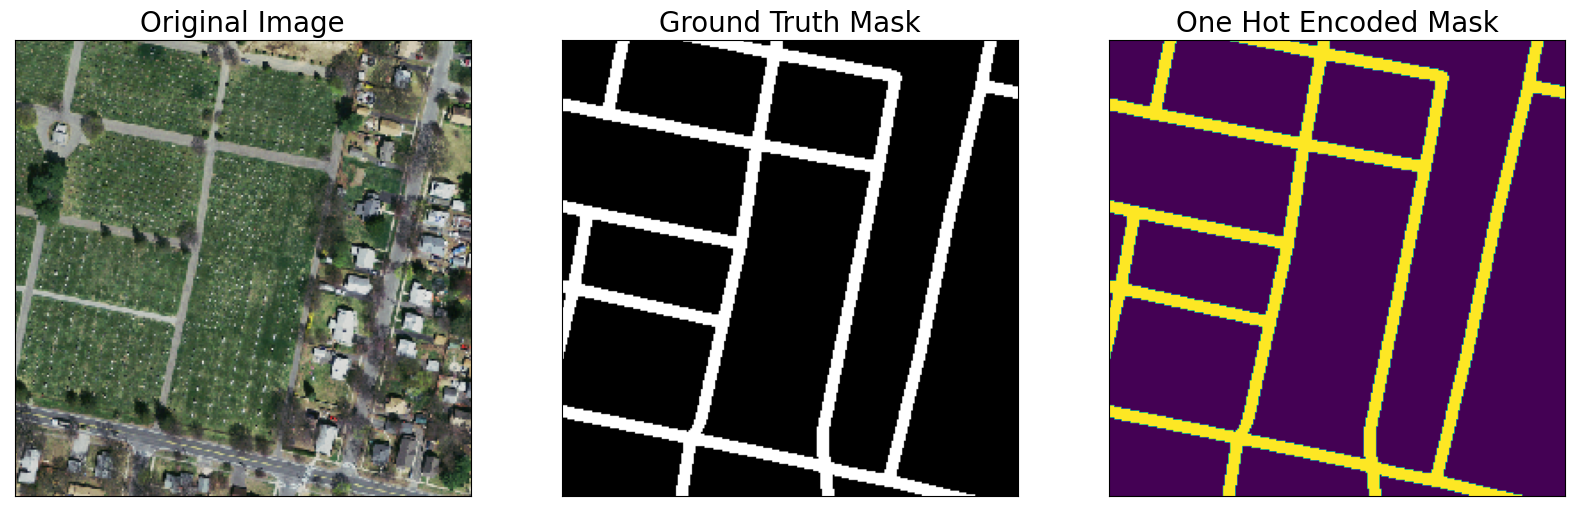

In [19]:
augmented_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )
#print(colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values))

In [20]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid'

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [21]:
train_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [22]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True
# Set num of epochs
EPOCHS = 25
# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define loss function
loss = smp_utils.losses.DiceLoss() #функция потерь дайс (что это и почему именно она??)
#
metrics = [smp.utils.metrics.IoU(threshold=0.5)]

#оптимизатор адам (повторить что это и в чём его приемущество, также что такое лр)
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.00008)])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)

#можно загрузить сохранённую пачку весов, чтоб каждый раз не проходить этот путь.....
if os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
    model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)

In [23]:
train_epoch = smp.utils.train.TrainEpoch( #
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [24]:
if TRAINING:
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 14/14 [00:02<00:00,  6.93it/s, dice_loss - 0.3501, iou_score - 0.6672]
Model saved!

Epoch: 1
valid: 100%|██████████| 14/14 [00:02<00:00,  6.90it/s, dice_loss - 0.2987, iou_score - 0.7796]
Model saved!

Epoch: 2
valid: 100%|██████████| 14/14 [00:02<00:00,  6.86it/s, dice_loss - 0.2518, iou_score - 0.8209]
Model saved!

Epoch: 3
valid: 100%|██████████| 14/14 [00:02<00:00,  6.78it/s, dice_loss - 0.2188, iou_score - 0.8305]
Model saved!

Epoch: 4
valid: 100%|██████████| 14/14 [00:02<00:00,  6.86it/s, dice_loss - 0.1995, iou_score - 0.8226]

Epoch: 5
valid: 100%|██████████| 14/14 [00:02<00:00,  6.71it/s, dice_loss - 0.1625, iou_score - 0.8412]
Model saved!

Epoch: 6
valid: 100%|██████████| 14/14 [00:02<00:00,  6.74it/s, dice_loss - 0.1405, iou_score - 0.8568]
Model saved!

Epoch: 7
valid: 100%|██████████| 14/14 [00:02<00:00,  6.72it/s, dice_loss - 0.1196, iou_score - 0.8706]
Model saved!

Epoch: 8
valid: 100%|██████████| 14/14 [00:02<00:00,  6.79it/s, dice

In [25]:
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

elif os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
    best_model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


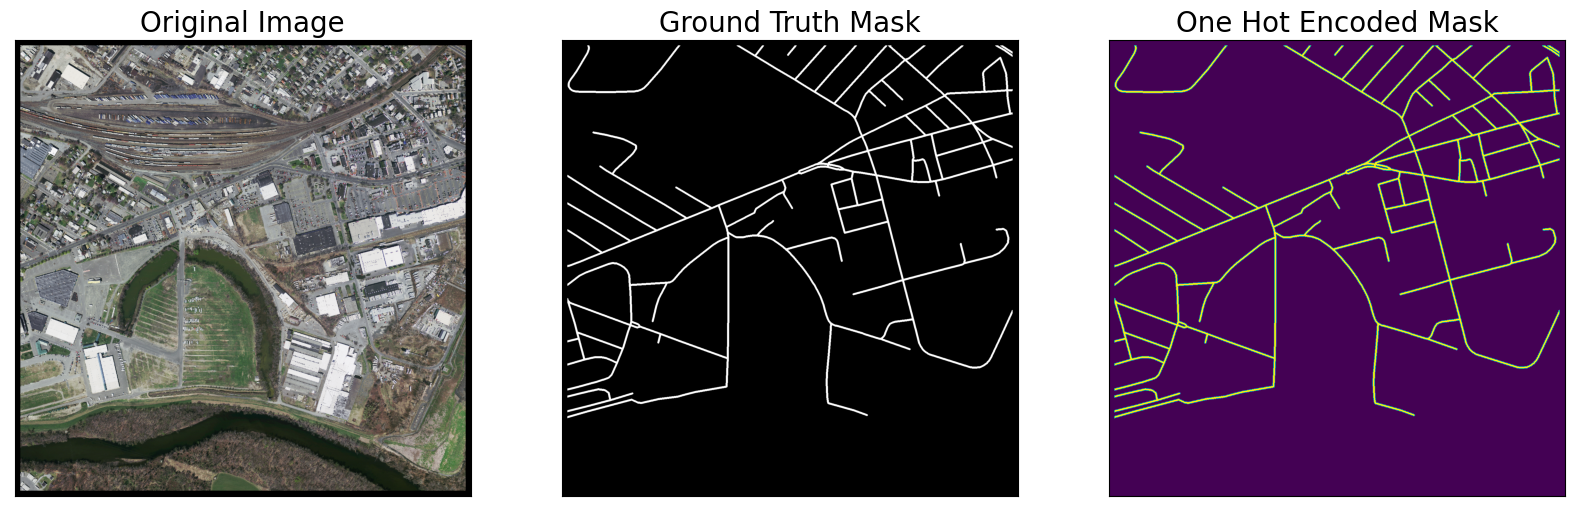

In [26]:
test_dataset = RoadsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

test_dataset_vis = RoadsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(test_dataset_vis)-1) #берём рандомные маску и пикчу чтобы чекнуть вывод
image, mask = test_dataset_vis[random_idx]

visualize(#вывод трёх пикч ориг, маска и ванхот
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [27]:
def crop_image(image, target_image_dims=[1500,1500,3]):
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2
    if padding<0:
        return image
    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [28]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [34]:
for idx in range(len(test_dataset)):
    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()#
    pred_mask = np.transpose(pred_mask,(1,2,0))#тип решейп для норм вывода
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

In [30]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 49/49 [00:17<00:00,  2.74it/s, dice_loss - 0.05263, iou_score - 0.9116]
Evaluation on Test Data: 
Mean IoU Score: 0.9116
Mean Dice Loss: 0.0526


In [31]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
dice_loss,0.397112,0.307998,0.254577,0.207624,0.170006,0.137086,0.112926,0.094893,0.080563,0.070973,...,0.046712,0.044014,0.042260,0.040602,0.039586,0.039046,0.036815,0.037387,0.036429,0.035312
iou_score,0.617896,0.774206,0.866264,0.894820,0.906920,0.916945,0.922190,0.930118,0.935744,0.937934,...,0.941123,0.942873,0.943541,0.944042,0.944160,0.943142,0.945802,0.943253,0.943905,0.944992
